In [1]:
# System libs
import os
import time
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.io import loadmat
# Our libs
from mit_semseg.config import cfg
from mit_semseg.dataset import ValDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm

import sys, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms

sys.path.insert(1, '/home/zyang/Documents/Noisey-image')

from noise_video_gen import *

from shutil import copyfile

In [2]:
import os
import cv2
import sys
import yaml
import time
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

##################### model stuff #####################
# System libs
import csv, torch, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.config import cfg
from mit_semseg.utils import colorEncode
from mit_semseg.dataset import ValDataset
from mit_semseg.lib.utils import as_numpy
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion, setup_logger

# pass in mode config(yaml file)
# return a dict for the file 
# return decoder and encoder weights path
def parse_model_config(path):
    with open(path) as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    
    encoder_path = None
    decoder_path = None

    for p in os.listdir(data['DIR']):
        if "encoder" in p.lower():
            encoder_path = "{}/{}".format(data['DIR'], p)
            continue
        if "decoder" in p.lower():
            decoder_path = "{}/{}".format(data['DIR'], p)
            continue

    if encoder_path==None or decoder_path==None:
        raise("model weights not found")
        
    return data, encoder_path, decoder_path

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    #if show==True:
        #display(PIL.Image.fromarray(im_vis))
    #else:
    return pred_color, im_vis

def process_img(path=None, frame=None):
    # Load and normalize one image as a singleton tensor batch
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])
    # pil_image = PIL.Image.open('../ADE_val_00001519.jpg').convert('RGB')
    if path!=None:
        pil_image = PIL.Image.open(path).convert('RGB')
    else:
        pil_image = PIL.Image.fromarray(frame)

    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]
    return (img_original, singleton_batch, output_size)

def predict_img(segmentation_module, singleton_batch, output_size):
    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    return pred


def get_color_palette(pred, bar_height):

    pred = np.int32(pred)
    pixs = pred.size

    top_left_y = 0
    bottom_right_y = 30
    uniques, counts = np.unique(pred, return_counts=True)

    # Create a black image
    # bar_height = im_vis.shape[0]
    img = np.zeros((bar_height,250,3), np.uint8)

    for idx in np.argsort(counts)[::-1]:
        color_index = uniques[idx]
        name = names[color_index + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("{}  {}: {:.2f}% {}".format(color_index+1, name, ratio, colors[color_index]))
            img = cv2.rectangle(img, (0,top_left_y), (250,bottom_right_y), 
                       (int(colors[color_index][0]),int(colors[color_index][1]),int(colors[color_index][2])), -1)
            img = cv2.putText(img, "{}: {:.3f}%".format(name, ratio), (0,top_left_y+20), 5, 1, (255,255,255), 2, cv2.LINE_AA)
            top_left_y+=30
            bottom_right_y+=30
            
    return img


def transparent_overlays(image, annotation, alpha=0.5):
    img1 = image.copy()
    img2 = annotation.copy()

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    # img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    # dst = cv2.add(img1_bg, img2_fg)
    dst = cv2.addWeighted(image.copy(), 1-alpha, img2_fg, alpha, 0)
    img1[0:rows, 0:cols ] = dst
    return dst


def evaluate(segmentation_module, loader, cfg, gpu):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    time_meter = AverageMeter()

    segmentation_module.eval()

    pbar = tqdm(total=len(loader), leave=False)
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        seg_label = as_numpy(batch_data['seg_label'][0])
        img_resized_list = batch_data['img_data']

        torch.cuda.synchronize()
        tic = time.perf_counter()
        with torch.no_grad():
            segSize = (seg_label.shape[0], seg_label.shape[1])
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                scores_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + scores_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        torch.cuda.synchronize()
        time_meter.update(time.perf_counter() - tic)

        # calculate accuracy
        acc, pix = accuracy(pred, seg_label)
        intersection, union = intersectionAndUnion(pred, seg_label, cfg.DATASET.num_class)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)

        # visualization
        if cfg.VAL.visualize:
            visualize_result(
                (batch_data['img_ori'], seg_label, batch_data['info']),
                pred,
                os.path.join(cfg.DIR, 'result')
            )

        pbar.update(1)

    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    #for i, _iou in enumerate(iou):
        #print('class [{}], IoU: {:.4f}'.format(i, _iou))

    #print('[Eval Summary]:')
    #print('Mean IoU: {:.4f}, Accuracy: {:.2f}%, Inference Time: {:.4f}s'
    #      .format(iou.mean(), acc_meter.average()*100, time_meter.average()))
    
    return pred, acc_meter.average()*100


# create a tmp_obgt for 1 img
def create_tmp_obgt(img_path, anno_path, width, height, tmp_path="tmp_results/tmp_eval.odgt"):
    eval_img = "{\"fpath_img\": " + "\"{}\", ".format(img_path) + "\"fpath_segm\": " + "\"{}\", ".format(anno_path) + \
                "\"width\": " + str(width) + ", \"height\": " + str(height) + "}"
    f = open(tmp_path, "w")
    f.write("{}".format(eval_img))
    f.close()
    
    
def setup_oneImg_loader(img_path, anno_path, tmp_path="tmp_results/tmp_eval.odgt", update=0):
    img = PIL.Image.open(img_path).convert('RGB')
    anno_rgb = PIL.Image.open(anno_path).convert('RGB')
    anno = PIL.Image.open(anno_path)
    anno = np.array(anno)
    anno[np.where(anno!=0)]-=1

    width = img.size[0]
    height = img.size[1]
    # im_vis = numpy.concatenate((img, anno_rgb), axis=1)
    # display(PIL.Image.fromarray(im_vis))
    if update==0:
        create_tmp_obgt(img_path, anno_path, width, height, tmp_path=tmp_path)
    
    # Dataset and Loader
    dataset_val = ValDataset("", tmp_path, cfg.DATASET)
    loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=1,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=1,
        drop_last=True)
    
    return loader_val

In [3]:
img_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg"
anno_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png"

tmp_img_path = '../tmp_results/tmp.jpg'

In [4]:
anno = PIL.Image.open(anno_path)
anno = np.array(anno)
anno[np.where(anno!=0)]-=1

'''
img = PIL.Image.open(img_path).convert('RGB')
anno_rgb = PIL.Image.open(anno_path).convert('RGB')

width = img.size[0]
height = img.size[1]

im_vis = numpy.concatenate((img, anno_rgb), axis=1)
display(PIL.Image.fromarray(im_vis))
'''
print()

In [5]:
'''
# Dataset and Loader
dataset_val = ValDataset("", "tmp_eval.odgt", cfg.DATASET)
loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=user_scattered_collate,
    num_workers=1,
    drop_last=True)
'''
print()

In [6]:
# colors
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

# parse cfg
cfg.merge_from_file("config/ade20k-resnet50dilated-ppm_deepsup.yaml")
# cfg.merge_from_list(opts)

# Network Builders
print("parsing {}".format("config/ade20k-resnet50dilated-ppm_deepsup.yaml"))
model_config, encoder_path, decoder_path = parse_model_config("config/ade20k-resnet50dilated-ppm_deepsup.yaml")
net_encoder = ModelBuilder.build_encoder(
    arch = model_config["MODEL"]['arch_encoder'],
    fc_dim = model_config['MODEL']['fc_dim'],
    weights = encoder_path)
net_decoder = ModelBuilder.build_decoder(
    arch = model_config["MODEL"]['arch_decoder'],
    fc_dim = model_config['MODEL']['fc_dim'],
    num_class = model_config['DATASET']['num_class'],
    weights = decoder_path,
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
# segmentation_module.eval()
segmentation_module.cuda()

# predict on 1 img
print("\nEvaluation on\nImages: {}\nAnnotation: {}\n".format(img_path, img_path))
#img_path = args.img
#anno_path = args.anno

parsing config/ade20k-resnet50dilated-ppm_deepsup.yaml
Loading weights for net_encoder
Loading weights for net_decoder

Evaluation on
Images: /home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg
Annotation: /home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg



In [7]:
tmp_img_path

'../tmp_results/tmp.jpg'

In [8]:
img_path

'/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg'

In [9]:
count = 0
all_amount = []
all_acc = []
pred_num_class = []

# noise
copyfile(img_path, tmp_img_path)

img = cv2.imread(tmp_img_path)
org_img = img.copy()

amount = 0.0
while(True):
    loader_val = setup_oneImg_loader(tmp_img_path, anno_path, tmp_path="../tmp_results/tmp_eval.odgt", update=0)
    segmentation_module.cuda()
    pred, acc = evaluate(segmentation_module, loader_val, cfg, 0)
    
    all_amount.append(amount)
    all_acc.append(acc)
    pred_num_class.append(len(np.unique(pred)))
    
    amount+=0.001
    # frame = saltAndPapper_noise(org_img, s_vs_p=0.5, amount=amount)
    frame = saltAndPapper_noise(org_img, amount)
    
    # overwrite tmp.jpg
    cv2.imwrite(tmp_img_path, frame)
    
    count+=1
    if count==5:
        break

  0%|          | 0/1 [00:00<?, ?it/s]

# samples: 1


  0%|          | 0/1 [00:00<?, ?it/s]

# samples: 1



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# samples: 1




100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

# samples: 1





100%|██████████| 1/1 [00:00<00:00,  1.62it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

# samples: 1






100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

In [10]:
all_acc

[90.93313963631054,
 89.40650682433093,
 87.26072021036,
 86.25713279770605,
 83.59147267888689]

In [11]:
pred_num_class

[13, 12, 12, 12, 12]

In [13]:
csv_name = 'tmp'
df = pd.DataFrame()
df['amount'] = all_amount
df['PixelAcc'] = all_acc
df['num_class'] = pred_num_class
df.head()

,amount,PixelAcc,num_class
0,0.000,90.933140,13
1,0.001,90.467188,12
2,0.002,89.375105,12
3,0.003,78.778440,12
4,0.004,63.714162,12


In [30]:
df = pd.read_csv('../tmp_results/s_p50.csv')
df

,amount,PixelAcc,num_class
0,0.0000,90.933140,13
1,0.0005,90.716182,13
2,0.0010,90.422782,13
3,0.0015,90.199480,12
4,0.0020,88.616705,12
5,0.0025,87.015533,11
6,0.0030,74.389807,12
7,0.0035,67.150909,11
8,0.0040,65.777479,11
9,0.0045,68.066001,11


In [ ]:
display(PIL.Image.fromarray(pred.astype(np.uint8)))

In [ ]:
# # classes for pred
len(np.unique(pred))

In [ ]:
len(np.unique(anno))

In [13]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None, show=True):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    if show==True:
        display(PIL.Image.fromarray(im_vis))
    else:
        return pred_color, im_vis

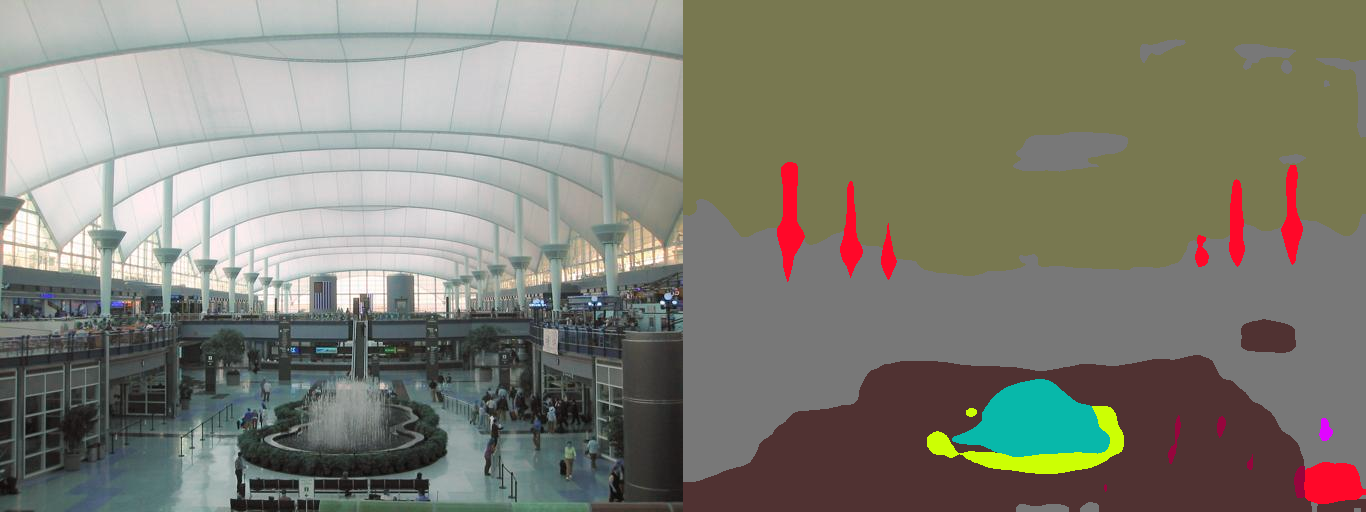

In [14]:
visualize_result(img, pred)

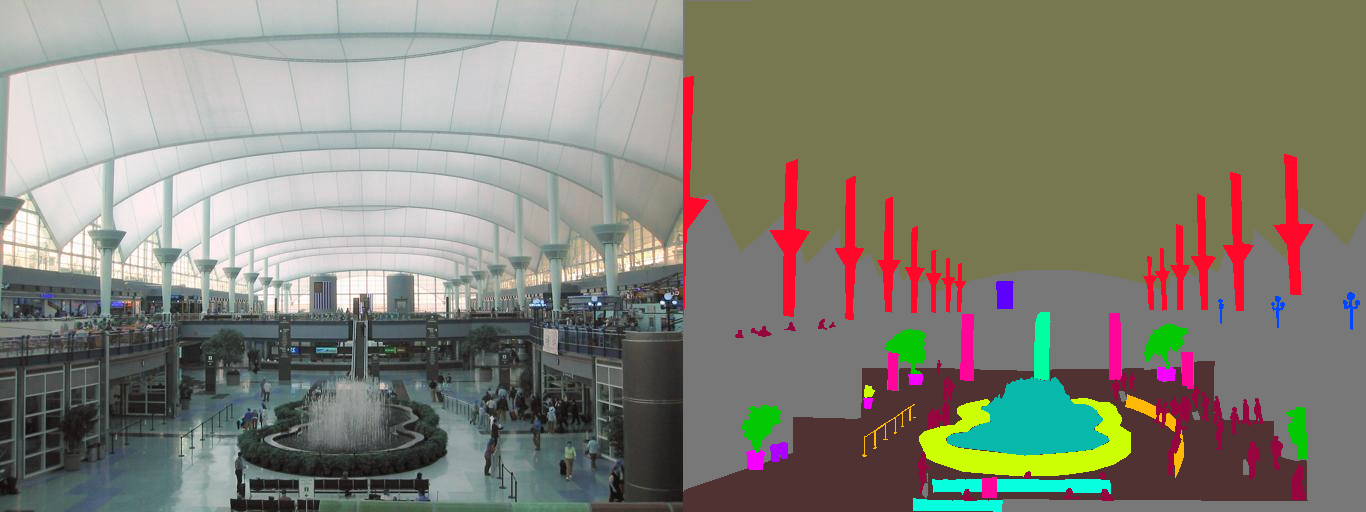

In [15]:
visualize_result(img, anno)

In [ ]:
np.unique(anno)

In [ ]:
len(np.unique(pred))

In [ ]:
# np.unique(np.append(np.unique(anno), np.unique(pred)))

In [ ]:
print(acc)